<a href="https://colab.research.google.com/github/raheelsiddiqi2013/fruit-grading/blob/main/EnsembleModelLocalSindhiGuavaGrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble Model for "Local Sindhi" Guava Grading
This notebook is written and executed by **Raheel Siddiqi, PhD**. Fruit grading of Local Sindhi guava is performed. It is a multi-class classification problem with three classes: "Green", "Mature Green", and "Ripe". The dataset consists of 711 images with a train-validation-test split of 70-15-15. An ensemble model is created by combining and averaging outputs from two classification models. The two classification models used in the ensemble model are created using transfer learning and are based on pre-trained models VGG16 and InceptionV3, respectively.  

## Connecting to Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/MyResearch/FruitGrading/LocalSindhi"

Test  Train  Validation


## Importing Relevant Libraries

In [ ]:
# Import
import numpy as np
from PIL import Image
import os

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16, InceptionV3

## Loading Data

In [ ]:
# Create Generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2
                                   )

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)


# Create Data Loaders
train_loader = train_datagen.flow_from_directory(
    directory = "/content/drive/MyDrive/MyResearch/FruitGrading/LocalSindhi/Train",
    target_size = (224, 224),
    batch_size = 32,
    shuffle = True
)

validation_loader= validation_datagen.flow_from_directory(
    directory = "/content/drive/MyDrive/MyResearch/FruitGrading/LocalSindhi/Validation",
    target_size = (224, 224),
    batch_size = 32,
    shuffle = True
)

test_loader = test_datagen.flow_from_directory(
    directory = "/content/drive/MyDrive/MyResearch/FruitGrading/LocalSindhi/Test",
    target_size = (224, 224),
    batch_size = 32,
    shuffle = True
)

Found 498 images belonging to 3 classes.
Found 107 images belonging to 3 classes.
Found 106 images belonging to 3 classes.


# Dataset Classes

In [ ]:
train_loader.class_indices

{'Green': 0, 'Mature Green': 1, 'Ripe': 2}

## First Model Compilation
The first model is trained using transfer learning and exploiting the pre-trained VGG16 model.

In [ ]:
from keras.callbacks import ModelCheckpoint
import keras

optimizer = keras.optimizers.Adam(lr=0.0001)
model1 = Sequential()
model1.add(VGG16(include_top = False, pooling = "avg"))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(3, activation='softmax'))
model1.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['categorical_accuracy'])

filepath="LocalSindhi_VGG16_best_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True)
callbacks_list = [checkpoint]

58889256/58889256 [==============================] - 2s 0us/step


## First Model Training

In [ ]:
import math

model1_train_history = model1.fit_generator(
    generator = train_loader,
    steps_per_epoch = math.ceil(498//32),
    epochs = 100,
    callbacks=callbacks_list,
    validation_data = validation_loader,
    validation_steps = math.ceil(107//32)
)

<ipython-input-7-f25ae04be7d3>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model1_train_history = model1.fit_generator(


Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 2.1064 - categorical_accuracy: 0.4227  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 1132s 74s/step - loss: 2.1064 - categorical_accuracy: 0.4227 - val_loss: 0.9702 - val_categorical_accuracy: 0.5000
Epoch 2/100
15/15 [==============================] - 1086s 73s/step - loss: 0.9896 - categorical_accuracy: 0.4936 - val_loss: 1.0176 - val_categorical_accuracy: 0.7917
Epoch 3/100
15/15 [==============================] - 1053s 70s/step - loss: 1.0108 - categorical_accuracy: 0.5064 - val_loss: 1.0091 - val_categorical_accuracy: 0.4688
Epoch 4/100
 4/15 [=======>......................] - ETA: 10:40 - loss: 0.9688 - categorical_accuracy: 0.5000

## Visualizing First Model Training

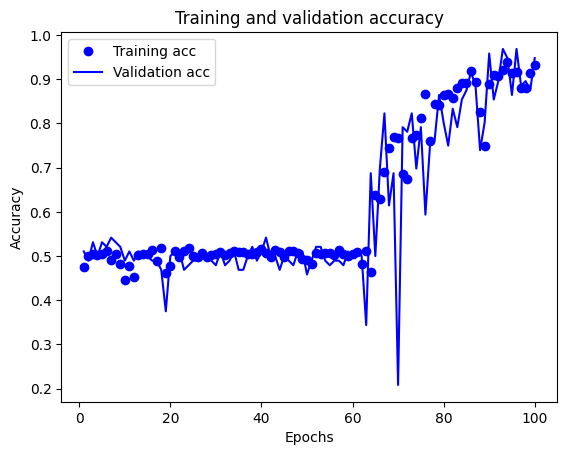

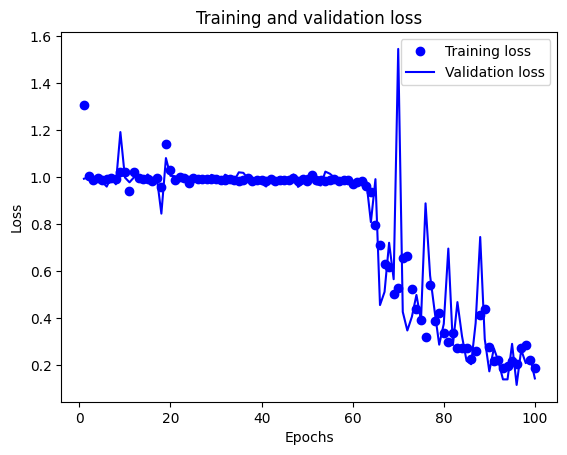

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

acc=model1_train_history.history['categorical_accuracy']
val_acc=model1_train_history.history['val_categorical_accuracy']
loss=model1_train_history.history['loss']
val_loss=model1_train_history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## First Model Evaluation

In [ ]:
# Preparing test data
import glob
from pathlib import Path
from tensorflow.keras.utils import to_categorical
import cv2

green_cases_dir = Path('/content/drive/MyDrive/MyResearch/FruitGrading/LocalSindhi/Test/Green')
mature_green_cases_dir = Path(r'/content/drive/MyDrive/MyResearch/FruitGrading/LocalSindhi/Test/Mature Green')
ripe_cases_dir= Path('/content/drive/MyDrive/MyResearch/FruitGrading/LocalSindhi/Test/Ripe')

green_cases = green_cases_dir.glob('*.jpg')
mature_green_cases = mature_green_cases_dir.glob('*.jpg')
ripe_cases = ripe_cases_dir.glob('*.jpg')

image_width=224
image_height=224

test_data = []
test_labels = []

for img in green_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (image_width,image_height))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [0]
    test_data.append(img)
    test_labels.append(label)

for img in mature_green_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (image_width,image_height))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [1]
    test_data.append(img)
    test_labels.append(label)

for img in ripe_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (image_width,image_height))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [2]
    test_data.append(img)
    test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)
test_labels_one_hot_encoding=to_categorical(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (106, 224, 224, 3)
Total number of labels: (106, 1)


### Test Set Accuracy

In [ ]:
from keras.models import load_model
best_model_VGG16 = load_model('LocalSindhi_VGG16_best_model.h5')
steps_test=int(106/32)
result = best_model_VGG16.evaluate_generator(test_loader, steps=steps_test,verbose=1)
print("Test-set accuracy: {0:.2%}".format(result[1]))

<ipython-input-15-386004040e86>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  result = best_model_VGG16.evaluate_generator(test_loader, steps=steps_test,verbose=1)


3/3 [==============================] - 1s 299ms/step - loss: 0.1333 - categorical_accuracy: 0.9583
Test-set accuracy: 95.83%


In [ ]:
# Get predictions
preds = best_model_VGG16.predict(test_data, batch_size=32)
preds=np.around(preds)
orig_test_labels=test_labels
predicted_labels=np.argmax(preds,axis=1)
predicted_labels=np.reshape(predicted_labels,(106,1))

4/4 [==============================] - 1s 132ms/step


### Confusion Matrix for the First Model

<Figure size 640x480 with 0 Axes>

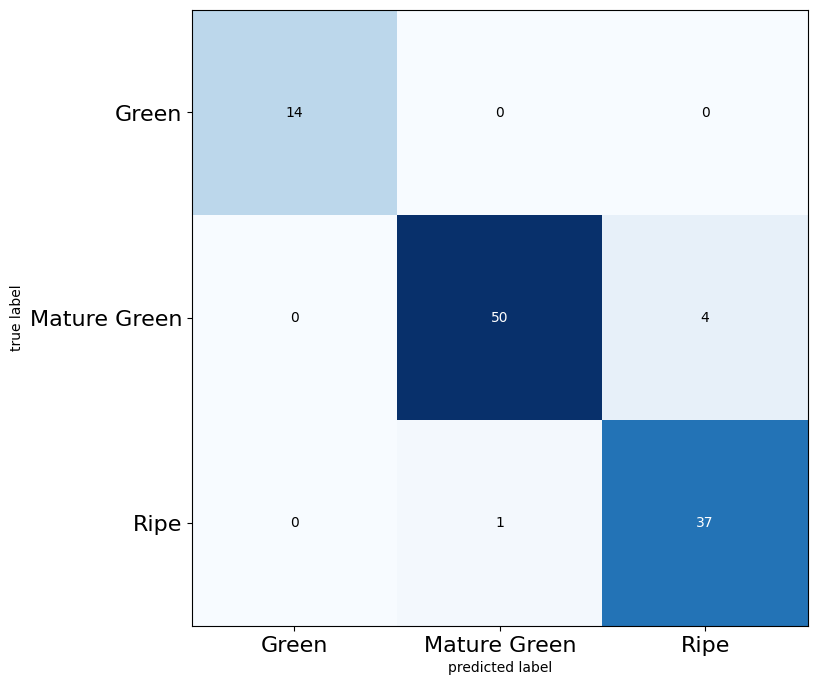

In [ ]:
# Get the confusion matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm  = confusion_matrix(orig_test_labels, predicted_labels)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(3), ['Green','Mature Green','Ripe'], fontsize=16)
plt.yticks(range(3), ['Green','Mature Green','Ripe'], fontsize=16)
plt.show()

## Second Model Compilation
The second model is also trained using transfer learning but the pre-trained model exploited is InceptionV3.

In [ ]:
optimizer2 = keras.optimizers.Adam(lr=0.0001)
model2 = Sequential()
model2.add(InceptionV3(include_top = False, pooling = "avg"))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(3, activation='softmax'))
model2.compile(loss='categorical_crossentropy',optimizer=optimizer2,metrics=['categorical_accuracy'])

filepath="LocalSindhi_InceptionV3_best_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True)
callbacks_list = [checkpoint]

## Second Model Training

In [ ]:
model2_train_history = model2.fit_generator(
    generator = train_loader,
    steps_per_epoch = math.ceil(498//32),
    epochs = 100,
    callbacks=callbacks_list,
    validation_data = validation_loader,
    validation_steps = math.ceil(107//32)
)

<ipython-input-23-f43d40c4c5ed>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model2_train_history = model2.fit_generator(


Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 0.7298 - categorical_accuracy: 0.7275

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 62s 1s/step - loss: 0.7298 - categorical_accuracy: 0.7275 - val_loss: 29.2968 - val_categorical_accuracy: 0.3229
Epoch 2/100
15/15 [==============================] - 13s 841ms/step - loss: 0.2909 - categorical_accuracy: 0.9099 - val_loss: 121.4360 - val_categorical_accuracy: 0.3438
Epoch 3/100
15/15 [==============================] - 12s 820ms/step - loss: 0.3357 - categorical_accuracy: 0.8970 - val_loss: 40.7003 - val_categorical_accuracy: 0.3542
Epoch 4/100
15/15 [==============================] - 14s 908ms/step - loss: 0.2240 - categorical_accuracy: 0.9142 - val_loss: 6.9918 - val_categorical_accuracy: 0.3750
Epoch 5/100
15/15 [==============================] - 13s 878ms/step - loss: 0.2697 - categorical_accuracy: 0.9250 - val_loss: 118.9709 - val_categorical_accuracy: 0.3438
Epoch 6/100
15/15 [==============================] - 12s 829ms/step - loss: 0.2226 - categorical_accuracy: 0.9249 - val_loss: 97.9469 - val_categorical_accuracy: 0.3542


## Second Model Training Visulaization

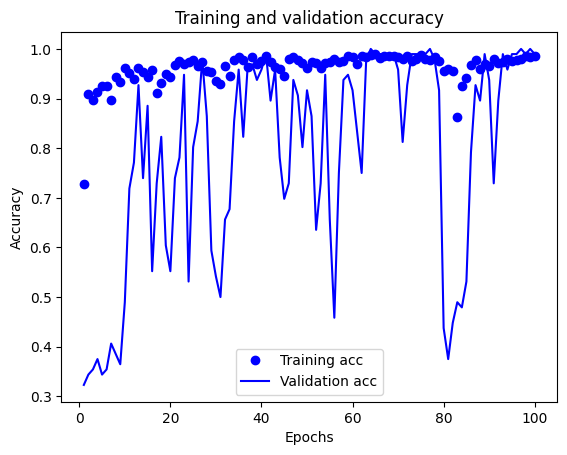

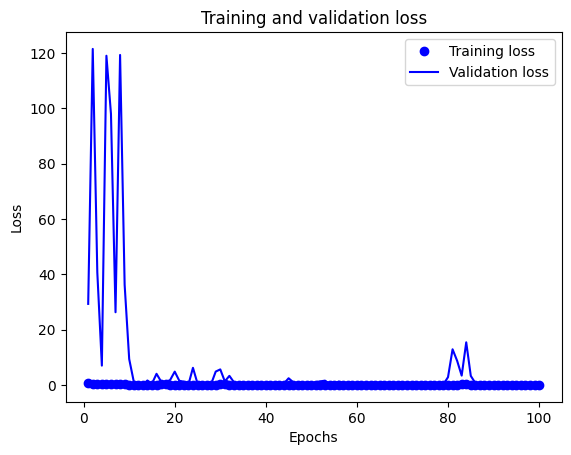

In [ ]:
acc=model2_train_history.history['categorical_accuracy']
val_acc=model2_train_history.history['val_categorical_accuracy']
loss=model2_train_history.history['loss']
val_loss=model2_train_history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Second Model Evaluation
### Test set Accuracy

In [ ]:
from keras.models import load_model
best_model_InceptionV3 = load_model('LocalSindhi_InceptionV3_best_model.h5')
steps_test=int(106/32)
result = best_model_InceptionV3.evaluate_generator(test_loader, steps=steps_test,verbose=1)
print("Test-set accuracy: {0:.2%}".format(result[1]))

<ipython-input-25-6672d75fcd45>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  result = best_model_InceptionV3.evaluate_generator(test_loader, steps=steps_test,verbose=1)


3/3 [==============================] - 2s 339ms/step - loss: 0.0562 - categorical_accuracy: 0.9688
Test-set accuracy: 96.88%


In [ ]:
# Get predictions
preds = best_model_InceptionV3.predict(test_data, batch_size=32)
preds=np.around(preds)
orig_test_labels=test_labels
predicted_labels=np.argmax(preds,axis=1)
predicted_labels=np.reshape(predicted_labels,(106,1))

4/4 [==============================] - 4s 786ms/step


### Confusion Matrix for the Second Model

<Figure size 640x480 with 0 Axes>

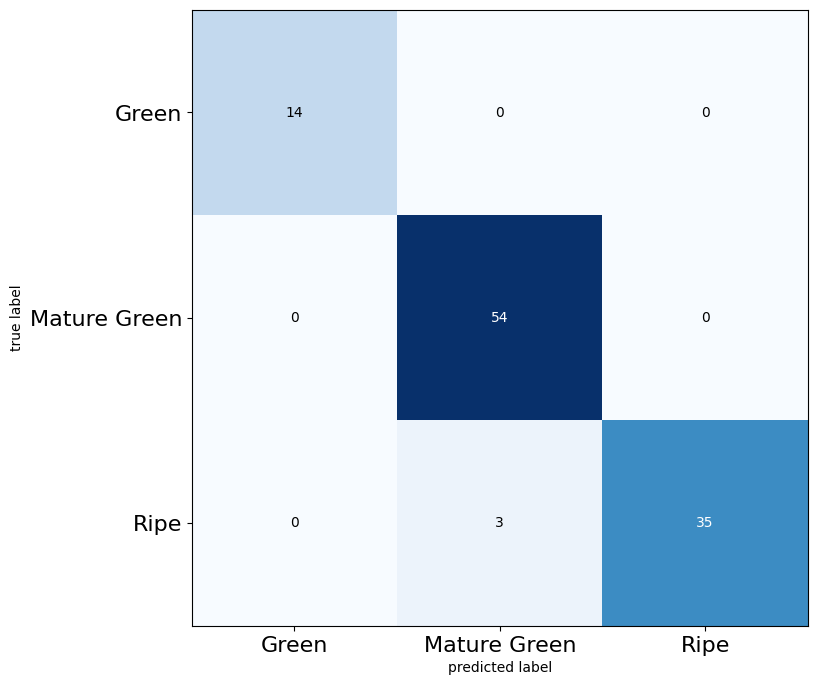

In [ ]:
# Get the confusion matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm  = confusion_matrix(orig_test_labels, predicted_labels)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(3), ['Green','Mature Green','Ripe'], fontsize=16)
plt.yticks(range(3), ['Green','Mature Green','Ripe'], fontsize=16)
plt.show()

## Ensemble Model Compilation

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model_1 = load_model('LocalSindhi_VGG16_best_model.h5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='LocalSindhi_VGG16_best_model.h5')
model_2 = load_model('LocalSindhi_InceptionV3_best_model.h5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='LocalSindhi_InceptionV3_best_model')
models = [model_1, model_2]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [ ]:
optimizer3 = keras.optimizers.Adam(lr=0.0001)
ensemble_model.compile(loss='categorical_crossentropy',optimizer=optimizer3,metrics=['categorical_accuracy'])

filepath="LocalSindhi_ensemble_model_best_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True)
callbacks_list = [checkpoint]

## Ensemble Model Training

In [ ]:
ensemble_model_train_history = ensemble_model.fit_generator(
    generator = train_loader,
    steps_per_epoch = math.ceil(498//32),
    epochs = 100,
    callbacks=callbacks_list,
    validation_data = validation_loader,
    validation_steps = math.ceil(107//32)
)

<ipython-input-30-058c6e689647>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  ensemble_model_train_history = ensemble_model.fit_generator(


Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 0.1719 - categorical_accuracy: 0.9678

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 60s 2s/step - loss: 0.1719 - categorical_accuracy: 0.9678 - val_loss: 0.4921 - val_categorical_accuracy: 0.6562
Epoch 2/100
15/15 [==============================] - 21s 1s/step - loss: 0.1736 - categorical_accuracy: 0.9571 - val_loss: 0.3693 - val_categorical_accuracy: 0.7812
Epoch 3/100
15/15 [==============================] - 15s 965ms/step - loss: 0.1067 - categorical_accuracy: 0.9700 - val_loss: 0.7073 - val_categorical_accuracy: 0.4375
Epoch 4/100
15/15 [==============================] - 16s 1s/step - loss: 0.1585 - categorical_accuracy: 0.9678 - val_loss: 0.3759 - val_categorical_accuracy: 0.7708
Epoch 5/100
15/15 [==============================] - 19s 1s/step - loss: 0.1247 - categorical_accuracy: 0.9614 - val_loss: 0.7584 - val_categorical_accuracy: 0.3438
Epoch 6/100
15/15 [==============================] - 24s 2s/step - loss: 0.1117 - categorical_accuracy: 0.9657 - val_loss: 0.8306 - val_categorical_accuracy: 0.4479
Epoch 7/100
15/15 [

## Ensemble Model Training Visualization

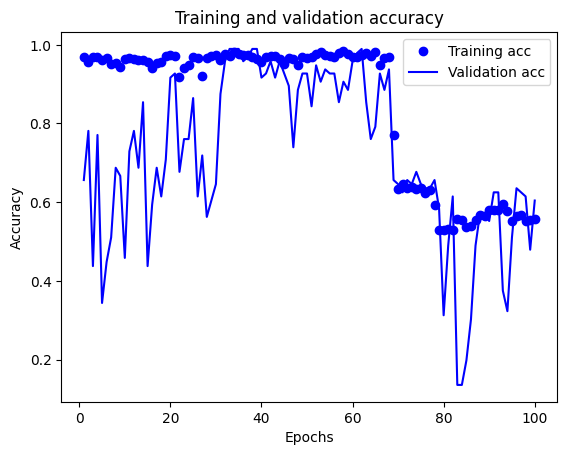

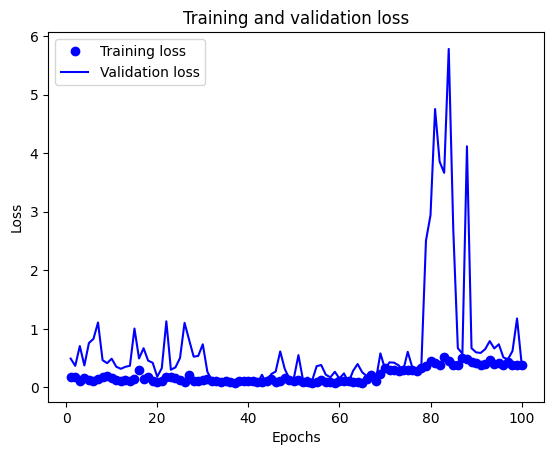

In [ ]:
acc=ensemble_model_train_history.history['categorical_accuracy']
val_acc=ensemble_model_train_history.history['val_categorical_accuracy']
loss=ensemble_model_train_history.history['loss']
val_loss=ensemble_model_train_history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Ensemble Model Evaluation
### Test Set Accuracy

In [ ]:
from keras.models import load_model
best_ensemble_model = load_model('LocalSindhi_ensemble_model_best_model.h5')
steps_test=int(106/32)
result = best_ensemble_model.evaluate_generator(test_loader, steps=steps_test,verbose=1)
print("Test-set accuracy: {0:.2%}".format(result[1]))

<ipython-input-33-76a951f6dc74>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  result = best_ensemble_model.evaluate_generator(test_loader, steps=steps_test,verbose=1)


3/3 [==============================] - 5s 537ms/step - loss: 0.0543 - categorical_accuracy: 0.9792
Test-set accuracy: 97.92%


In [ ]:
# Get predictions
preds = best_ensemble_model.predict(test_data, batch_size=32)
preds=np.around(preds)
orig_test_labels=test_labels
predicted_labels=np.argmax(preds,axis=1)
predicted_labels=np.reshape(predicted_labels,(106,1))

4/4 [==============================] - 3s 201ms/step


### Confusion Matrix for the Ensemble Model

<Figure size 640x480 with 0 Axes>

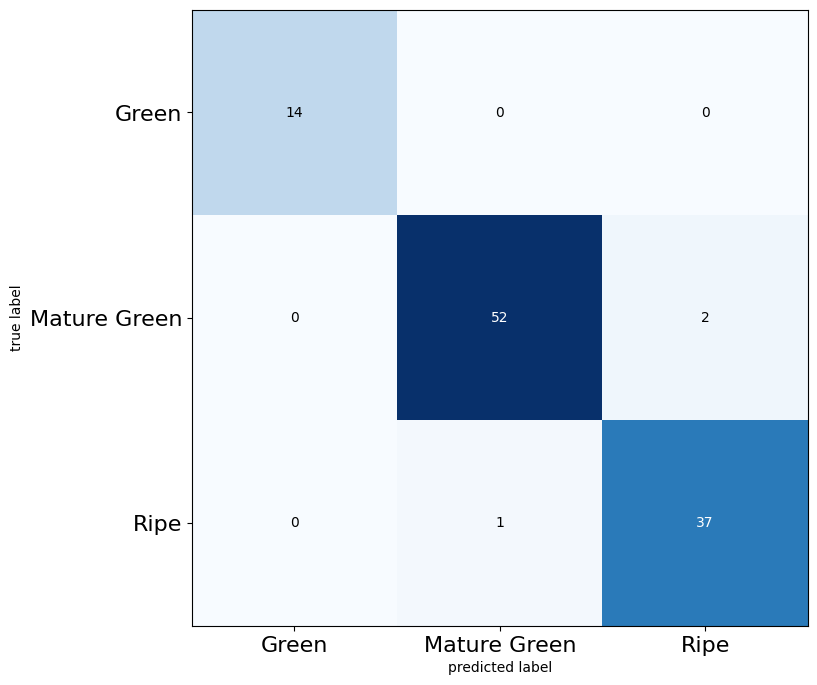

In [ ]:
# Get the confusion matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm  = confusion_matrix(orig_test_labels, predicted_labels)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(3), ['Green','Mature Green','Ripe'], fontsize=16)
plt.yticks(range(3), ['Green','Mature Green','Ripe'], fontsize=16)
plt.show()